**Name:** David Björelind

**EID:** 40107147

**Kaggle Team Name:** \_\_\_\_\_

# CS4487 - Assignment 2 - Sound Effects Retrieval
Due date: November 5, 2018, 11:59pm

## Final submission
In this file, put the code that generates your final Kaggle submission. It will be used to verify that your Kaggle submission is reproducible.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
random.seed(100)
import csv
from scipy import io
import pickle
from IPython.display import Audio, display

/Users/davidbjorelind/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/davidbjorelind/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/davidbjorelind/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This mod

In [8]:
def showAudio(info):
    display(Audio(info['previews']['preview-lq-mp3']))

def load_pickle(fname):
    f = open(fname, 'rb')
    out = pickle.load(f)
    f.close()
    return out
# compute delta MFCCs
def compute_delta_mfccs(mfccs):
    dmfccs = []
    for m in mfccs:
        tmp = m[1:] - m[0:-1]
        dm = hstack((m[0:-1], tmp))
        dmfccs.append(dm)
    return dmfccs

In [9]:
train_tags = load_pickle('sounds-data/train_tags.pickle3')
train_mfccs = load_pickle('sounds-data/train_mfccs.pickle3')
train_info = load_pickle('sounds-data/train_info.pickle3')

valid_mfccs = load_pickle('sounds-data/val_mfccs.pickle3')
valid_info = load_pickle('sounds-data/val_info.pickle3')
valid_matches = load_pickle('sounds-data/val_matches.pickle3')

test_mfccs = load_pickle('sounds-data/test_mfccs.pickle3')
test_info = load_pickle('sounds-data/test_info.pickle3')

In [10]:
def nn_retr(testX, trainX):
    # do retrieval using nearest neighbors
    # for each entry in testX, find the top 10 closest entries in trainX using Euclidean distance
    
    test_retr = []  # retrieval list

    # for each test document vector
    for tX in testX:
        # calculate the distance between tX and all training document vectors
        # (using Euclidean distance)
        if tX.ndim == 1:
            ttX = tX.reshape((1,tX.shape[0]))
        else:
            ttX = tX;
        D = metrics.pairwise_distances(ttX, trainX, metric='euclidean')
        Df = D.flatten()
        
        # find the 10 with smallest distance
        # (faster: bestmatches are the top-10, but not sorted yet)
        bestmatches_unsorted = argpartition(Df, 10)[0:10]
                
        # now sort bestmatches
        bestmatches_tmp = argsort(Df[bestmatches_unsorted])
        bestmatches = bestmatches_unsorted[bestmatches_tmp]        
        
        # slow, since it sorts everything
        #bestmatches = argsort(D.flatten())[0:10]
    
        # add to retrieval list
        test_retr.append(bestmatches)

    return test_retr

In [11]:
def calc_MAP(Ytrue, Ypred, K=10):
    # calculate the mean average precision
    # returns the MAP for the whole set, and the AP for each document
    
    AP = zeros(len(Ytrue))
    # for each document
    for j in range(len(Ytrue)):
        Yt = Ytrue[j]
        if not isinstance(Yt, ndarray):
            Yt = array([Yt])
        Yp = Ypred[j]
        # calculate average precision @ K
        nummatches = 0.
        score = 0.
        for i,y in enumerate(Yp[0:K]):
            # if match at this level, calculate P
            if any(y==Yt):
                nummatches += 1.
                P = nummatches / (i+1)
                score += P
        AP[j] = score / K #min(K, len(Yt))

    # mean over all documents
    MAP = mean(AP)
    return (MAP, AP)

# write a kaggle submission file for retrieval
def write_csv_kaggle_retr_sub(fname, Yretr):
    # header
    tmp = [['Id', 'RetrievedDocuments']]
    
    # add ID numbers for each Y, and usage if necessary
    for i in range(len(Yretr)):
        y = Yretr[i]
        ystr = [str(q) for q in y]
        tmp2 = [str(i+1)]
        tmp2.append(" ".join(ystr))        
        tmp.append(tmp2)
        
    # write CSV file
    f = open(fname, 'w')
    writer = csv.writer(f)
    writer.writerows(tmp)
    f.close()

In [16]:
def transform_back(mfccs_old, mfccs_new):
    res = []
    count = 0
    
    for i in range(len(mfccs_old)):
        l = len(mfccs_old[i][0:])
        res.append(mfccs_new[count:(count+l)])
        count = count + l
        
    return res

def bow_transform(model, mfccs):
    numwords = model.cluster_centers_.shape[0]
    bows = zeros((len(mfccs), numwords))
    for i in range(len(mfccs)):
        w = model.predict(mfccs[i])
        bw = bincount(w, minlength=numwords)
        bows[i,:] = bw
    return bows

def bow_transform_gmm(model, mfccs):
    numwords = model.means_.shape[0]
    bows = zeros((len(mfccs), numwords))
    for i in range(len(mfccs)):
        w = model.predict(mfccs[i])
        bw = bincount(w, minlength=numwords)
        bows[i,:] = bw
    return bows

In [17]:
### YOUR CODE HERE
        
# put dmfccs from all training data together
all_dmfccs = vstack(train_dmfccs)
print(all_dmfccs.shape)
    
train_dmfccs = compute_delta_mfccs(train_mfccs)
test_dmfccs  = compute_delta_mfccs(test_mfccs)
valid_dmfccs = compute_delta_mfccs(valid_mfccs)    
    
km = cluster.KMeans(n_clusters=150, random_state=4487)
km.fit(all_dmfccs[0::10])  # subsample by 10 to make it faster
km.cluster_centers_

(600481, 26)


array([[-7.38815618e+02,  1.72449215e+02, -1.85898429e+01, ...,
         7.42454087e-02, -5.04306114e-01,  3.08636882e-01],
       [-1.02004023e+03,  1.34856386e+02,  7.71997882e+01, ...,
         2.41933590e-01,  2.51675630e-01,  1.61385735e-01],
       [-6.72067043e+02,  7.59130335e+01,  7.01766489e+01, ...,
        -6.13579875e-03, -2.14294845e-01,  2.41305004e-01],
       ...,
       [-7.52902654e+02, -1.26343595e+02,  5.48628060e+01, ...,
        -1.00780610e+00, -3.18284275e-01,  1.40783781e+00],
       [-8.87405451e+02,  1.52550850e+02,  6.04181172e+01, ...,
         2.79577005e-03,  4.09611401e-01,  3.50560063e-01],
       [-5.08493766e+02,  7.06847755e+01, -3.30373249e+01, ...,
        -1.17586895e-01,  6.71954493e-01,  2.65956873e-01]])

0.1129935275080906


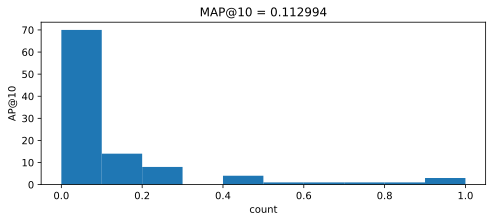

In [18]:


# creating BOW
train_bow = bow_transform(km, train_dmfccs)
test_bow  = bow_transform(km, test_dmfccs)
valid_bow = bow_transform(km, valid_dmfccs)
# convert to TF
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
train_Xtf = tf_trans.fit_transform(train_bow)
test_Xtf  = tf_trans.transform(test_bow)
valid_Xtf = tf_trans.transform(valid_bow)
# do retrieval
test_retr = nn_retr(test_Xtf, train_Xtf)
val_retr  = nn_retr(valid_Xtf, train_Xtf)
# evaluate on the validation set with P@10
vMAP,vAP = calc_MAP(valid_matches, val_retr)
print(vMAP)
plt.figure(figsize=(8,3))
plt.hist(vAP)
plt.title('MAP@10 = %g' % (vMAP,))
plt.xlabel('count')
plt.ylabel('AP@10');
write_csv_kaggle_retr_sub("davidbjorelindtest.csv", test_retr)